# Studying FEL UQ - MIC calculation

### In this notebook, the following is done: 
For the FEL gas detector data, the maximum information coefficient is calculated for all 76 input dimensions to determine which are minimally informative.

In [1]:
%load_ext autoreload
%autoreload 2


import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import time
import basicFunctions as bf
import pickle
from minepy import MINE
### Colorblind friendly colors:

colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255],
          [213/255,94/255,0], [0,114/255,178/255]]

import QuantRegUtils as qru
import matplotlib.style
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 15}
mpl.rc('font', **font)




#### Load Data

In [2]:
PATH = "datasets/"
NAME = "compiled_"
inputdf = pd.read_csv(PATH + NAME +'X.csv') 
outputdf = pd.read_csv(PATH + NAME + 'Y.csv') 

#### Take a look at the input variables

In [3]:
variable_names = inputdf.columns[1:]

output_names = outputdf.columns[1:]

view = True
## View the names and indicies of each variable
if view:
    for i, v in enumerate(variable_names):
        print(i, v)

0 ACCL_IN20_400_L0B_ADES
1 ACCL_LI21_1_L1S_ADES
2 ACCL_LI21_1_L1S_PDES
3 ACCL_LI22_1_ADES
4 ACCL_LI22_1_PDES
5 ACCL_LI25_1_ADES
6 ACCL_LI25_1_PDES
7 BEND_LI21_231_EDES
8 BEND_DMP1_400_BDES
9 BLEN_LI21_265_AIMAX1H
10 BLEN_LI24_886_BIMAX1H
11 BPMS_DMP1_693_TMIT1H
12 BPMS_LI21_201_TMIT1H
13 BPMS_LI21_278_TMIT1H
14 CAMR_IN20_186_SUM
15 CAMR_IN20_186_XRMS
16 CAMR_IN20_186_YRMS
17 CATH_IN20_111_QE
18 COLL_LI21_235_LVPOS
19 COLL_LI21_236_LVPOS
20 DCHP_LTU1_545_DS_GW_RBK
21 DCHP_LTU1_545_US_GW_RBK
22 DCHP_LTU1_555_DS_GW_RBK
23 DCHP_LTU1_555_US_GW_RBK
24 FBCK_FB04_LG01_CHIRPDES
25 FBCK_FB04_LG01_DL2VERNIER
26 FBCK_FB04_LG01_S3DES
27 FOIL_LI24_804_LVPOS
28 FOIL_LI24_804_MOTR.VAL
29 FOIL_LI24_807_LVPOS
30 FOIL_LI24_807_MOTR.VAL
31 LASR_IN20_196_PWR1H
32 LASR_LR20_1_UV_LASER_MODE
33 LGPS_IN20_1_BACT
34 LGPS_IN20_2_BACT
35 PMTR_LR20_121_PWR
36 PMTR_LR20_135_PWR
37 QUAD_IN20_121_BCTRL
38 QUAD_IN20_122_BCTRL
39 QUAD_IN20_361_BCTRL
40 QUAD_IN20_371_BCTRL
41 QUAD_IN20_425_BCTRL
42 QUAD_IN20_441_BCTRL
4

#### Data manipulations

The following cell converts the dataframe to numpy arrays and applies the following cuts to the data: 

1) Removing extraneous data: no output values should be less than 0 (units) or greater than 5 (units).


Original shape of data, before cutting out extraneous data or selected HXR samples:
Input values: (286923, 77)
Output values: (286923,)
Removed 0.646515% of full dataset, eliminating extraneous values
Final shape of data, after cutting out extraneous data:
Input values: (285068, 76)
Output values: (285068,)


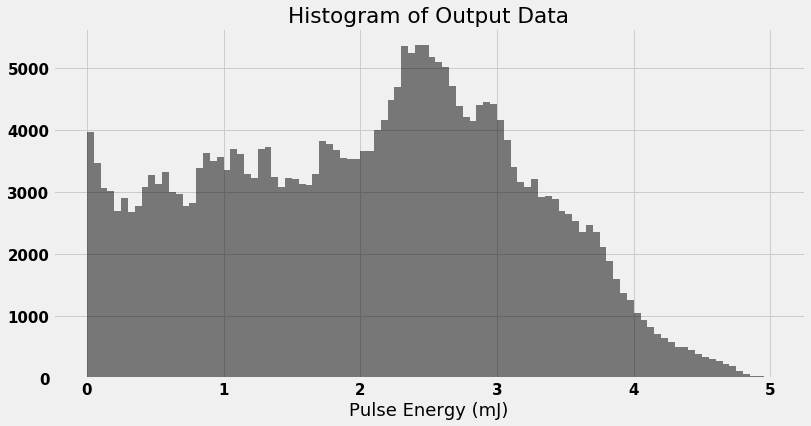

In [4]:
input_data = inputdf.to_numpy()
output_data = outputdf.to_numpy()
## Removing "index column"
output_data = output_data[:,1]


print("Original shape of data, before cutting out extraneous data or selected HXR samples:")
print("Input values: " + str(np.shape(input_data)))
print("Output values: " + str(np.shape(output_data)))

mask = np.where(np.logical_and(output_data>0, output_data<5))

## apply mask and cut out "index column"

removed_perc = 100*(np.shape(output_data)[0] - np.shape(output_data[mask])[0])/(np.shape(output_data)[0] )

input_data = input_data[mask[0], 1:]
output_data = output_data[mask]

print("Removed {:2f}% of full dataset, eliminating extraneous values".format(removed_perc))



print("Final shape of data, after cutting out extraneous data:")
print("Input values: " + str(np.shape(input_data)))
print("Output values: " + str(np.shape(output_data)))

plt.figure(figsize = (12,6))
plt.title("Histogram of Output Data")
plt.xlabel("Pulse Energy (mJ)")
plt.hist(output_data, 100, facecolor = colors[0], alpha = 0.5)
plt.show()

#### Examine Data

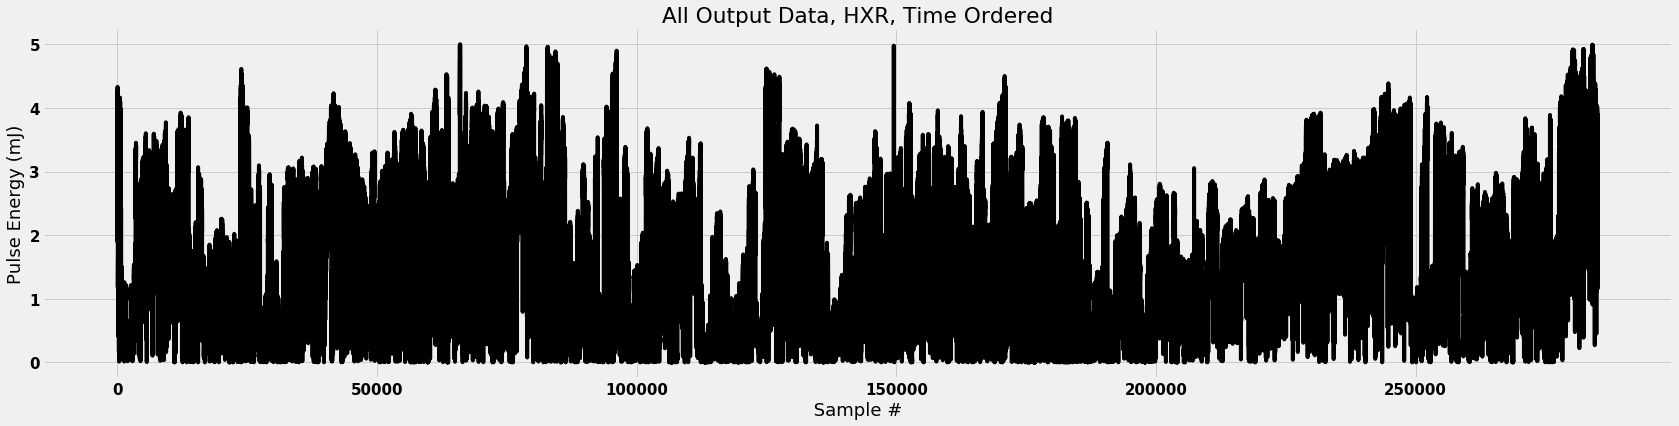

In [5]:
## Take a look at all of the output data
plt.figure(figsize= (26,6))
plt.plot(output_data, color = colors[0])
plt.ylabel("Pulse Energy (mJ)")
plt.xlabel(" Sample # ")
plt.title("All Output Data, HXR, Time Ordered")
plt.show()

## MIC calculation

Because the MIC calculation can take a long time (can be updated to using a parallellization method such as dask), just pick out subsets of the data for the calculation, and compute MICs for each subset.

In [6]:
## Once this is calculated, you can just load the calculated MICs
# temps = []

# for i in range(10):
#     print(i)
#     X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size = 0.075)
#     print(np.shape(X_test))
#     temp = np.zeros((len(variable_names),1))
#     mn = MINE(alpha = 0.6, c = 15, est = 'mic_approx')
#     for i in range(len(variable_names)):
#         mn.compute_score(X_test[:,i], y_test)
#         temp[i,0] = mn.mic()
        
#     temps.append(temp)
    
    
    
# temps = np.array(temps)
# temps = temps[:,:,0]
# print("DONE!!!!")
# #np.save("MIC_110420.npy", temps)

In [7]:
temps = np.load("MIC_110420.npy")

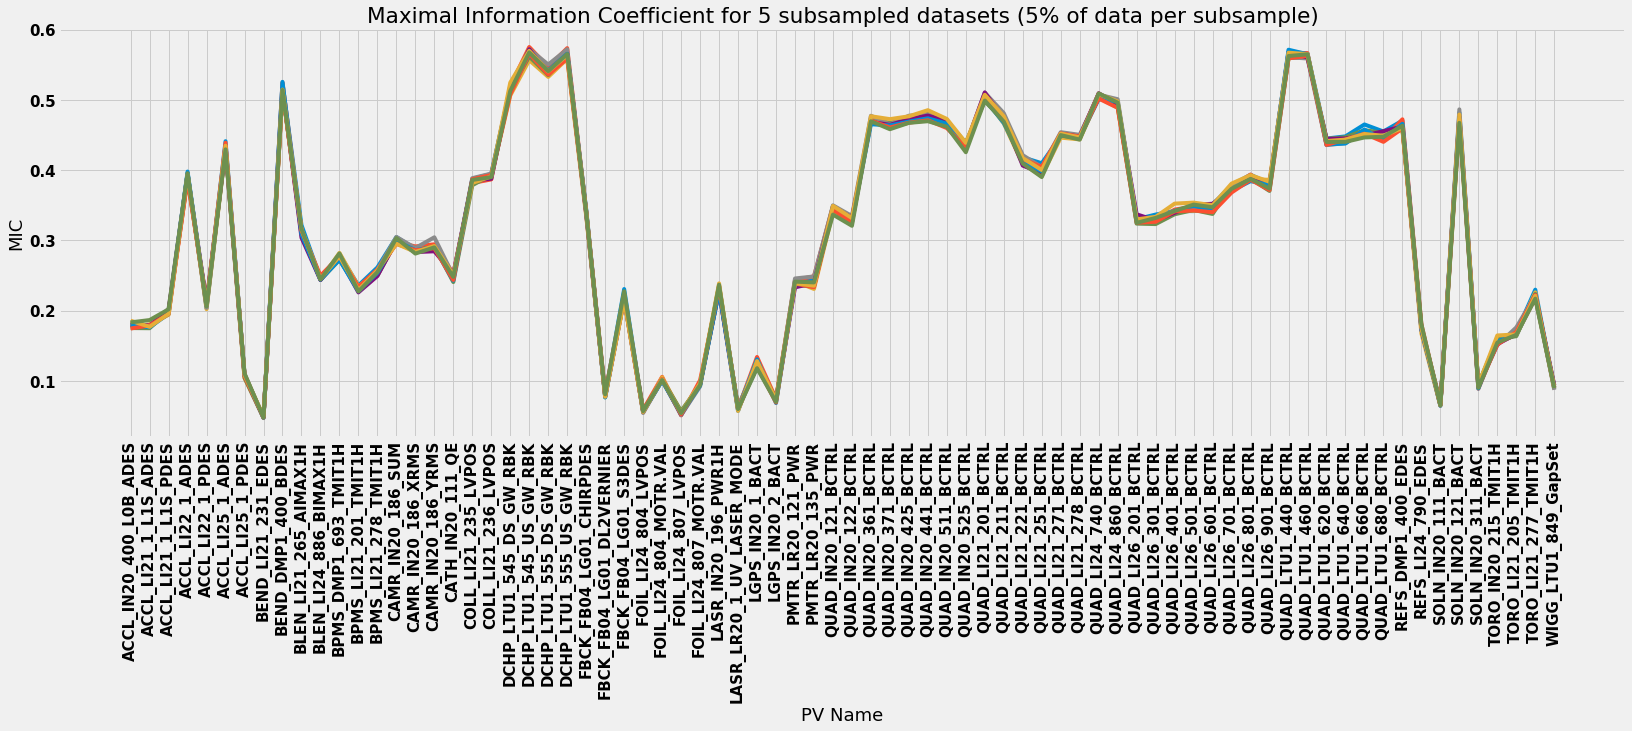

In [8]:
plt.figure(figsize = (25,7))
for i in range(10):
    plt.plot(variable_names, temps[i,:])
    plt.xlabel("PV Name")
    plt.ylabel("MIC")
    plt.title("Maximal Information Coefficient for 5 subsampled datasets (5% of data per subsample)")
    plt.xticks(rotation=90)
plt.show()


In [9]:
### Remove inputs that are minimally informative
mics = np.mean(temps, axis = 0)
idstokeep = np.argwhere(mics > 0.15).flatten()

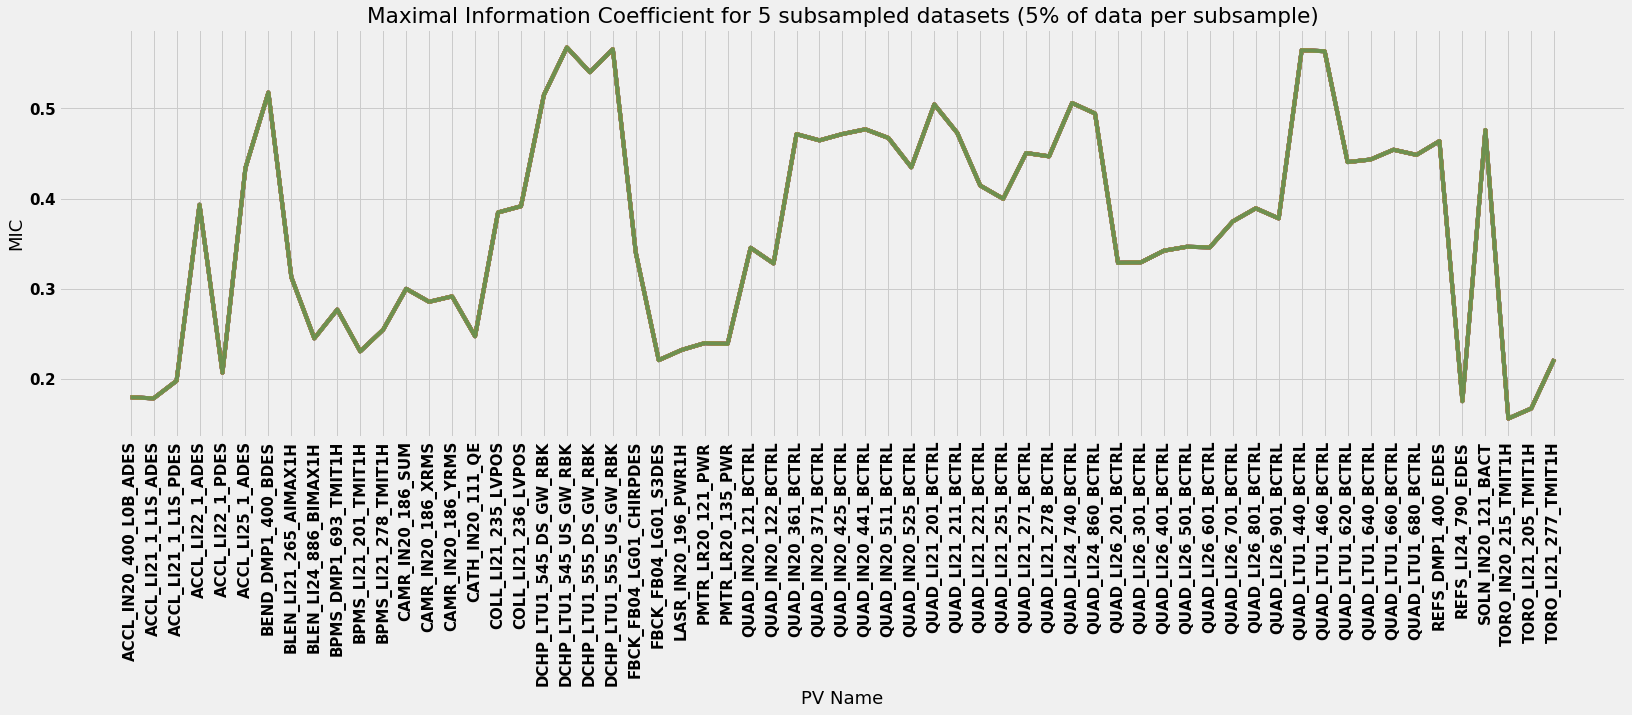

In [10]:
plt.figure(figsize = (25,7))
for i in range(10):
    plt.plot(variable_names[idstokeep], mics[idstokeep])
    plt.xlabel("PV Name")
    plt.ylabel("MIC")
    plt.title("Maximal Information Coefficient for 5 subsampled datasets (5% of data per subsample)")
    plt.xticks(rotation=90)
plt.show()


Original shape of data, before cutting out extraneous data or selected HXR samples:
Input values: (286923, 77)
Output values: (286923,)
Removed 0.646515% of full dataset, eliminating extraneous values
Final shape of data, after cutting out extraneous data:
Input values: (285068, 63)
Output values: (285068,)


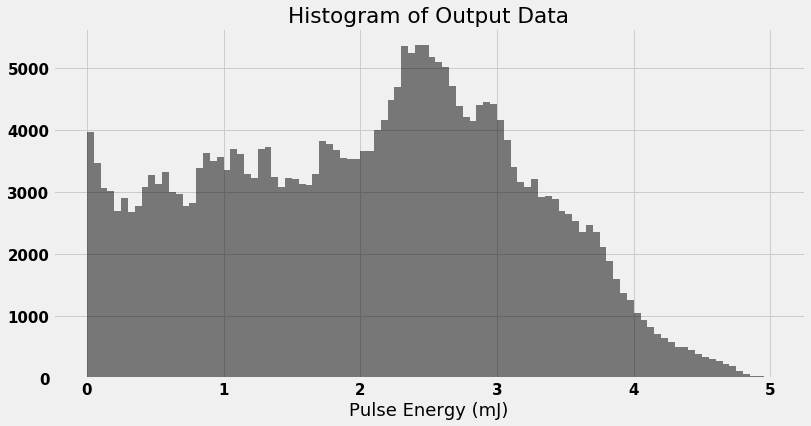

In [11]:
input_data = inputdf.to_numpy()
output_data = outputdf.to_numpy()
## Removing "index column"
output_data = output_data[:,1]


print("Original shape of data, before cutting out extraneous data or selected HXR samples:")
print("Input values: " + str(np.shape(input_data)))
print("Output values: " + str(np.shape(output_data)))

mask = np.where(np.logical_and(output_data>0, output_data<5))

## apply mask and cut out "index column"

removed_perc = 100*(np.shape(output_data)[0] - np.shape(output_data[mask])[0])/(np.shape(output_data)[0] )

input_data = input_data[mask[0], 1:]
output_data = output_data[mask]

print("Removed {:2f}% of full dataset, eliminating extraneous values".format(removed_perc))

input_data = input_data[:,idstokeep]

print("Final shape of data, after cutting out extraneous data:")
print("Input values: " + str(np.shape(input_data)))
print("Output values: " + str(np.shape(output_data)))

plt.figure(figsize = (12,6))
plt.title("Histogram of Output Data")
plt.xlabel("Pulse Energy (mJ)")
plt.hist(output_data, 100, facecolor = colors[0], alpha = 0.5)
plt.show()




In [12]:
PATH = ""
MODEL_NAME = "MIC/"
loading = True
if loading:
    x_scales = np.load(PATH + MODEL_NAME + "x_scales.npy")
    x_offsets = np.load(PATH + MODEL_NAME + "x_offsets.npy")
    y_scale = np.load(PATH + MODEL_NAME + "y_scale.npy")
    y_offset = np.load(PATH + MODEL_NAME + "y_offset.npy")
    x_scaled = np.load(PATH + MODEL_NAME + "x_scaled.npy")
    y_scaled = np.load(PATH + MODEL_NAME + "y_scaled.npy")
else:
    x_scaled, x_scales, x_offsets = bf.do_scaling(input_data, -1, 1)
    y_offset, y_scale= bf.get_scale(output_data)

    y_scaled = bf.scale_data(output_data, y_offset, y_scale, -1,1)
    
    np.save(PATH + MODEL_NAME + "x_scales.npy", x_scales)
    np.save(PATH + MODEL_NAME + "x_offsets.npy", x_offsets)
    np.save(PATH + MODEL_NAME + "y_scale.npy", y_scale)
    np.save(PATH + MODEL_NAME + "y_offset.npy", y_offset)
    np.save(PATH + MODEL_NAME + "x_scaled.npy", x_scaled)
    np.save(PATH + MODEL_NAME + "y_scaled.npy", y_scaled)

x, y, d = qru.scaling_and_dict(input_data, output_data)

In [14]:
training_models = False

if training_models:

    X_train, X_test, Y_train, Y_test = train_test_split(input_data, output_data, test_size = 0.2, random_state = 42)
    X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.5, random_state = 42)

    input_dict = {}
    input_dict["train"] = X_train
    input_dict["val"] = X_val
    input_dict["test"] = X_test

    output_dict = {}
    output_dict["train"] = Y_train
    output_dict["val"] = Y_val
    output_dict["test"] = Y_test

    with open(PATH + "MIC/inputs.pkl", 'wb') as f:
        pickle.dump(input_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

    with open(PATH + "MIC/outputs.pkl", 'wb') as f:
        pickle.dump(output_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
        
    #### Set up some parameters
    epochs = 5000
    batch_size = 4096
    PATH = "MIC/"

    median = qru.Model(scaling_dict = d, PATH = PATH, NAME = "median_pred_", QUANTILE = 0.5, input_dimension =  np.shape(input_data)[1])
    median.train_on_split_data(input_dict, output_dict, epochs = epochs, batch_size = batch_size)


    upper = qru.Model(scaling_dict = d, PATH = PATH, NAME = "upper_pred_", QUANTILE = 0.975, input_dimension =  np.shape(input_data)[1])
    upper.train_on_split_data(input_dict, output_dict, epochs = epochs, batch_size = batch_size)


    lower = qru.Model(scaling_dict = d, PATH = PATH, NAME = "lower_pred_", QUANTILE = 0.025, input_dimension =  np.shape(input_data)[1])
    lower.train_on_split_data(input_dict, output_dict, epochs = epochs, batch_size = batch_size)
    
    print("Completed")
else:

    PATH = "MIC/"
    MODEL_NAME = ""
    NN = MODEL_NAME + "median_pred_Model_Weights.h5"
    LB = MODEL_NAME + "lower_pred_Model_Weights.h5"
    UB = MODEL_NAME + "upper_pred_Model_Weights.h5"

    with open(PATH + "inputs.pkl", 'rb') as f:
        input_dict = pickle.load(f, encoding="utf-8")

    with open(PATH + "outputs.pkl", 'rb') as f:
        output_dict = pickle.load(f, encoding="utf-8")

    median = qru.Model(PATH = PATH, NAME = NN, scaling_dict = d, input_dimension =  np.shape(input_data)[1])   
    median.load()

    upper = qru.Model(PATH = PATH, NAME = UB, scaling_dict = d, input_dimension =  np.shape(input_data)[1])   
    upper.load()

    lower = qru.Model(PATH = PATH, NAME = LB, scaling_dict = d, input_dimension =  np.shape(input_data)[1])   
    lower.load()
    print("All models loaded")
    


    
    

All models loaded


In [15]:
out = output_dict["test"]
median_pred = median.evaluate(input_dict["test"])
ub_pred = upper.evaluate(input_dict["test"])
lb_pred = lower.evaluate(input_dict["test"])


In [16]:
coverage = np.logical_and(out > lb_pred[:,0], out < ub_pred[:,0])
coverage = np.array([int(elem) for elem in coverage])
coverage_percent = 100*np.sum(coverage)/len(out)

print("The percent of measured values within the confidence interval is: {:2.2f}%".format(coverage_percent))

The percent of measured values within the confidence interval is: 92.09%


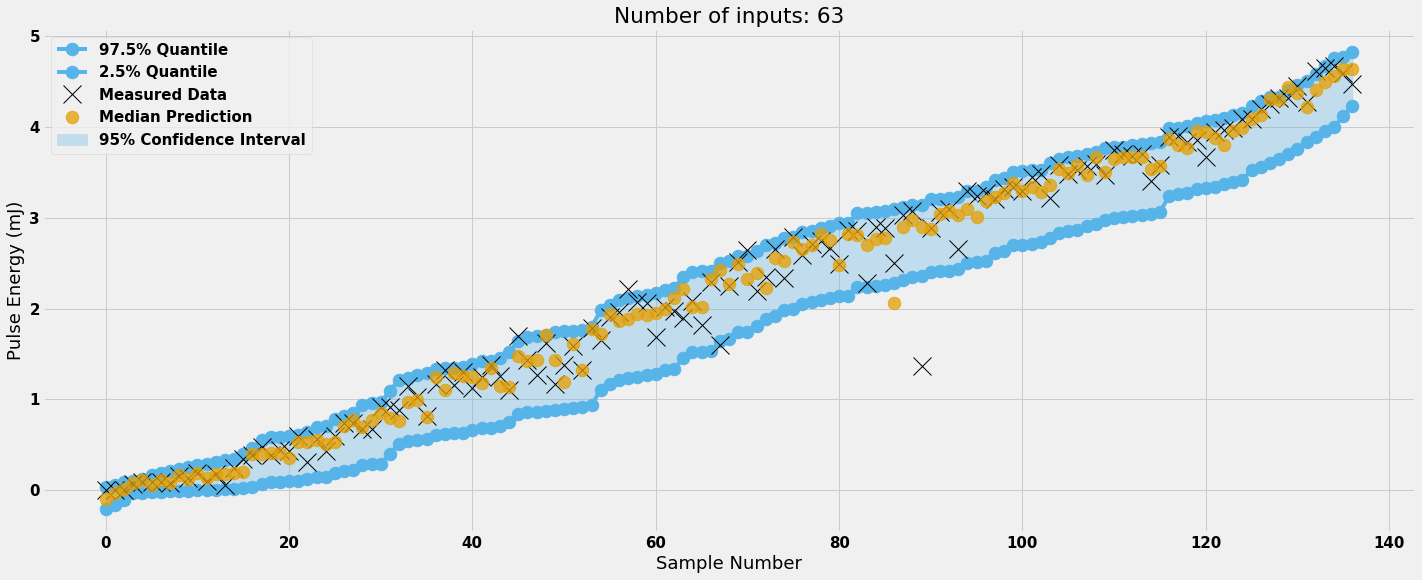

In [17]:

qru.plot_sorted_predictions(ub_pred, lb_pred, median_pred, out)

plt.tight_layout()
#plt.savefig("QR-Base-test-sorted.png", transparent = True)
plt.title("Number of inputs: " + str(np.shape(input_data)[1]))
plt.show()